# Exploring the Decay Position Network

This is repeating a little bit of the work that Rachel did - but going straight to a training. This notebook will use keras.

## Config

In [1]:
func_adl_endpoint = 'http://localhost:8000'
datasets_for_training_datafile = "../data/datasets.csv"

# Constants derived in previous notebook. Need to be added to a python file of config constants.
lxyz_eta_division = 1.3
too_far_dist_lz = 7500
too_far_dist_lxy = 4400
too_short_dist_lxy=1300
too_short_dist_lz=3500

# How many events per training sample shall we train on?
training_events_per_sample = 4000
epochs_to_train = 250

# Columns to train on. This is partly gotten by looking at the `Input Variables` worksheet to remove blanks.
what_to_train_on = ['EMM_BL0', 'EMM_BL1', 'EMM_BL2',
       'EMM_BL3', 'EMM_EL0', 'EMM_EL1', 'EMM_EL2', 'EMM_EL3', 'EH_EL0',
       'EH_EL1', 'EH_EL2', 'EH_CBL0', 'EH_CBL1', 'EH_CVL2',
       'EH_TGL0', 'EH_TGL1', 'EH_TGL2', 'EH_EBL0', 'EH_EBL1', 'EH_EBL2']
# With an eta cut of 1.3, then EH_EL3 is also all zeros.
#  'FC_L0', 'FC_L1', 'FC_L2' - these seem to be all zeros as seen before.

## Python setup

In [2]:
# Designed not to be modified
import sys
sys.path.append("../")
from adl_func_client.event_dataset import EventDataset
from adl_func_client.use_exe_func_adl_server import use_exe_func_adl_server
from calratio_perjet_training.fetch_training_data import fetch_perjet_data
import glob
import numpy as np
import asyncio

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import rcParams
plt.rc('font', size=14)
import seaborn as sns

import pandas as pd
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

from keras.models import Sequential
from keras.layers import Dense, Dropout
import sklearn.metrics

Using TensorFlow backend.


## Load datasets

In [3]:
datasets = pd.read_csv(datasets_for_training_datafile)

In [4]:
async def fetch_data_async(info):
    return [info, f'{info.mH}_{info.mS}_{info.Lifetime}_{info.MCCampaign}', await fetch_perjet_data(EventDataset(f'localds://{info.RucioDSName}'), f'{info.mH}_{info.mS}_{info.Lifetime}_{info.MCCampaign}')]
all_datasets_future = [fetch_data_async(info) for index, info in datasets.iterrows()]
datasets_for_training = await asyncio.gather(*all_datasets_future)

We need to split into training and testing sample sizes. Unfortunately, we have to do some calculations to understand if something is good signal to train on, or not. So we add a few columns here to all the datasets.

In [5]:
def add_useful_columns(ds):
    ds['Lxy'] = np.sqrt(ds.Lx*ds.Lx + ds.Ly*ds.Ly)

    ds['IsOutlier'] = False
    ds['IsOutlier'] |= ds.Lxy[ds.IsLLP & (np.abs(ds.JetEta) < lxyz_eta_division)] > too_far_dist_lxy
    ds['IsOutlier'] |= ds.Lz[ds.IsLLP & (np.abs(ds.JetEta) >= lxyz_eta_division)] > too_far_dist_lz

    ds['IsInlier'] = False
    ds['IsInlier'] |= ds.Lxy[ds.IsLLP & (np.abs(ds.JetEta) < lxyz_eta_division)] < too_short_dist_lxy
    ds['IsInlier'] |= ds.Lz[ds.IsLLP & (np.abs(ds.JetEta) >= lxyz_eta_division)] < too_short_dist_lz

    ds['JetIsCentral'] = np.abs(ds.JetEta) < lxyz_eta_division

    ds["Signal"] = ds.IsLLP & (ds.JetPt > 40) & (np.abs(ds.JetEta) < 2.4) & (ds.IsOutlier == False) & (ds.IsInlier == False) & (ds.JetIsCentral == True)

# We can limit how many datasets we combine to make life a little easier for testing with this line
what_to_combine = datasets_for_training #[20:35]
for d in what_to_combine:
    add_useful_columns(d[2])

In [6]:
all_training_jets = pd.DataFrame(pd.concat([d[2][d[2].Signal][:training_events_per_sample] for d in what_to_combine], keys=[(d[0].mH, d[0].mS, d[0].Lifetime, f'{d[0].mH}/{d[0].mS}', d[0].MCCampaign) for d in what_to_combine], names=['mH', 'mS', 'Lifetime', 'mH_mS', 'MC']).to_records())
all_testing_jets = pd.DataFrame(pd.concat([d[2][d[2].Signal][training_events_per_sample+1:] for d in what_to_combine], keys=[(d[0].mH, d[0].mS, d[0].Lifetime, f'{d[0].mH}/{d[0].mS}', d[0].MCCampaign) for d in what_to_combine], names=['mH', 'mS', 'Lifetime', 'mH_mS', 'MC']).to_records())

In [7]:
print (f'Number of training jets: {len(all_training_jets)}')
print (f'Number of testing jets: {len(all_testing_jets)}')

Number of training jets: 232000
Number of testing jets: 2379621


And quick reference for the columns we have in the data

In [8]:
all_training_jets.columns

Index(['mH', 'mS', 'Lifetime', 'mH_mS', 'MC', 'entry', 'RunNumber',
       'EventNumber', 'JetPt', 'JetEta', 'JetPhi', 'IsLLP', 'nLLPs_Near_Jets',
       'Lx', 'Ly', 'Lz', 'Leta', 'Lphi', 'EMM_BL0', 'EMM_BL1', 'EMM_BL2',
       'EMM_BL3', 'EMM_EL0', 'EMM_EL1', 'EMM_EL2', 'EMM_EL3', 'EH_EL0',
       'EH_EL1', 'EH_EL2', 'EH_EL3', 'EH_CBL0', 'EH_CBL1', 'EH_CVL2',
       'EH_TGL0', 'EH_TGL1', 'EH_TGL2', 'EH_EBL0', 'EH_EBL1', 'EH_EBL2',
       'FC_L0', 'FC_L1', 'FC_L2', 'Lxy', 'IsOutlier', 'IsInlier',
       'JetIsCentral', 'Signal'],
      dtype='object')

## Normalization

For this training best to center thinngs around the average before doing the training (or inference). Create some tools to do that.

In [9]:
def calc_normalization (p):
    return (p.mean(), p.std())

(input_mean, input_std) = calc_normalization(all_training_jets.filter(items=what_to_train_on))
(output_mean, output_std) = calc_normalization(all_training_jets.filter(items=['Lxy']))

def norm_inputs(p):
    return (p - input_mean) / input_std

def norm_outputs(p):
    return (p - output_mean[0]) / output_std[0]

def unnorm_outputs(p):
    return (p * output_std[0]) + output_mean[0]

In [10]:
y_train = norm_outputs(all_training_jets.Lxy)
x_train = norm_inputs(all_training_jets.filter(items=what_to_train_on))

In [11]:
x_train

,EMM_BL0,EMM_BL1,EMM_BL2,EMM_BL3,EMM_EL0,EMM_EL1,EMM_EL2,EMM_EL3,EH_EL0,EH_EL1,EH_EL2,EH_CBL0,EH_CBL1,EH_CVL2,EH_TGL0,EH_TGL1,EH_TGL2,EH_EBL0,EH_EBL1,EH_EBL2
0,-0.580908,-0.410386,-0.807111,-0.379692,-0.084544,-0.126568,-0.135053,-0.065668,-0.04283,-0.020237,0.002399,-0.756461,-0.102343,3.302753,-0.168017,-0.133278,-0.366506,-0.260278,-0.374604,-0.373570
1,-0.697450,-0.629773,-0.778616,-0.309159,-0.084544,-0.126568,-0.135053,-0.065668,-0.04283,-0.020237,0.002399,-0.789304,-0.834234,-0.378642,-0.234150,-0.160507,-0.210063,-0.283815,5.665190,-0.366189
2,0.176871,-0.686045,-0.780858,-0.258940,-0.084544,-0.126568,-0.135053,-0.065668,-0.04283,-0.020237,0.002399,-0.778450,-0.826380,-0.378642,0.573814,-0.186246,8.639295,0.487483,0.924923,-0.319386
3,-0.249725,-0.014288,-0.719359,-0.487174,-0.084544,-0.126568,-0.135053,-0.065668,-0.04283,-0.020237,0.002399,2.558789,-0.392911,-0.373599,-0.217953,-0.160507,-0.366506,-0.260278,-0.374604,-0.373570
4,-0.469085,-0.564468,-0.774007,-0.541422,-0.084544,-0.126568,-0.135053,-0.065668,-0.04283,-0.020237,0.002399,2.208852,0.102296,-0.380083,-0.217953,-0.160507,-0.366506,-0.260278,-0.374604,-0.373570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231995,0.307912,1.546554,1.212646,-0.199757,-0.084544,-0.126568,-0.135053,-0.065668,-0.04283,-0.020237,0.002399,-0.222384,-0.128156,-0.358739,-0.217953,-0.160507,-0.366506,-0.260278,-0.374604,-0.373570
231996,-0.146180,0.010200,-0.349318,-0.505263,-0.084544,-0.126568,-0.135053,-0.065668,-0.04283,-0.020237,0.002399,-0.734886,1.897781,-0.207021,-0.220039,-0.161252,-0.366506,-0.260278,-0.374604,-0.373570
231997,-0.007410,-0.575289,-0.731372,-0.411628,-0.084544,-0.126568,-0.135053,-0.065668,-0.04283,-0.020237,0.002399,-0.610896,-0.836650,-0.378812,6.645609,1.311835,-0.351150,-0.268523,-0.261102,2.313777
231998,0.170568,0.451603,1.106048,0.192996,-0.084544,-0.126568,-0.135053,-0.065668,-0.04283,-0.020237,0.002399,0.328544,-0.330579,-0.332461,-0.217953,-0.166724,-0.366506,-0.260278,-0.374604,-0.373570


## Build the Model

In [12]:
%%capture --no-stdout --no-display

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=len(x_train.columns)))
#model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
# THis is the number of outputs - so could be 2 if we wanted to train both lxy and lz
# Activation might be softmax if we had more than one thing as we would would want it to some to some number.
# But since this is regression, we do not.
model.add(Dense(1))

#categorical_crossentropy
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=32, epochs=epochs_to_train, validation_split=0.25, shuffle=True);

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 174000 samples, validate on 58000 samples
Epoch 1/250
174000/174000 [==============================] - 4s 23us/step - loss: 0.1086 - val_loss: 0.1373
Epoch 2/250
174000/174000 [==============================] - 4s 22us/step - loss: 0.0852 - val_loss: 0.1277
Epoch 3/250
174000/174000 [==============================] - 4s 22us/step - loss: 0.0757 - val_loss: 0.1308
Epoch 4/250
174000/174000 [==============================] - 4s 23us/step - loss: 0.0750 - val_loss: 0.1249
Epoch 5/250
174000/174000 [==============================] - 4s 23us/step - loss: 0.0722 - val_loss: 0.1298
Epoch 6/250
174000/174000 [==============================] - 4s 22us/step - loss: 0.0715 - val_loss: 0.1247
Epoch 7/250
174000/174000 [==============================] - 4s 23us/step - loss: 0.0707 - val_loss: 0.1269
Epoch 8/250
174000/174000 [==============================] - 4s 22us/step - loss: 0.0704 - val_loss: 0.1239
Epoch 9/250
174000/174000 [==============================] - 4s 22us/step - loss: 0.0

## Predict

This is a little tricky in the sense we want to run the prediction for the whole table. We split out the testing stuff above. So normalize it and we are ready to go!
Note we have to un-normalize things before we get to plotting and comparing!

In [13]:
x_test = norm_inputs(all_testing_jets.filter(items=what_to_train_on))

In [14]:
y_predict = model.predict(x_test)

In [15]:
all_testing_jets['p_Lxy'] = np.array(unnorm_outputs(y_predict[:,0]))

## Comparisons

Lets look at how well the prediction does vs various things

In [16]:
all_testing_jets

,mH,mS,Lifetime,mH_mS,MC,entry,RunNumber,EventNumber,JetPt,JetEta,...,EH_EBL2,FC_L0,FC_L1,FC_L2,Lxy,IsOutlier,IsInlier,JetIsCentral,Signal,p_Lxy
0,60,5,5,60/5,mc16a,19117,284500.0,2032282.0,60.924664,-1.207007,...,0.933253,0.0,0.0,0.0,3280.111273,False,False,True,True,3429.772217
1,60,5,5,60/5,mc16a,19127,284500.0,2032887.0,60.295883,-0.588621,...,0.000000,0.0,0.0,0.0,2239.233143,False,False,True,True,2194.183838
2,60,5,5,60/5,mc16a,19130,284500.0,2032801.0,54.427445,-1.198150,...,0.016063,0.0,0.0,0.0,2037.947500,False,False,True,True,2426.745361
3,60,5,5,60/5,mc16a,19132,284500.0,2031417.0,42.629125,0.667567,...,0.000000,0.0,0.0,0.0,2240.604653,False,False,True,True,2287.276123
4,60,5,5,60/5,mc16a,19135,284500.0,2032000.0,43.995914,0.637233,...,0.000000,0.0,0.0,0.0,2821.145652,False,False,True,True,2886.646484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2379616,1000,475,5,1000/475,mc16e,1694001,310000.0,2629376.0,181.651281,-1.239083,...,0.016764,0.0,0.0,0.0,2162.256447,False,False,True,True,2099.438965
2379617,1000,475,5,1000/475,mc16e,1694004,310000.0,2628209.0,105.929453,-0.094589,...,0.000000,0.0,0.0,0.0,2241.621594,False,False,True,True,1842.852051
2379618,1000,475,5,1000/475,mc16e,1694009,310000.0,2628463.0,607.340875,-0.460089,...,0.000000,0.0,0.0,0.0,2479.446553,False,False,True,True,2343.844727
2379619,1000,475,5,1000/475,mc16e,1694019,310000.0,2629903.0,208.756359,0.050490,...,0.000000,0.0,0.0,0.0,2235.145844,False,False,True,True,2163.949463


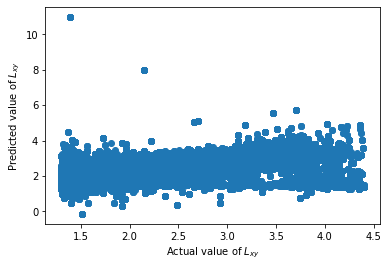

In [17]:
plt.scatter(x=all_testing_jets.Lxy/1000.0, y=all_testing_jets.p_Lxy/1000.0)
plt.xlabel('Actual value of $L_{xy}$')
plt.ylabel('Predicted value of $L_{xy}$')
plt.show()

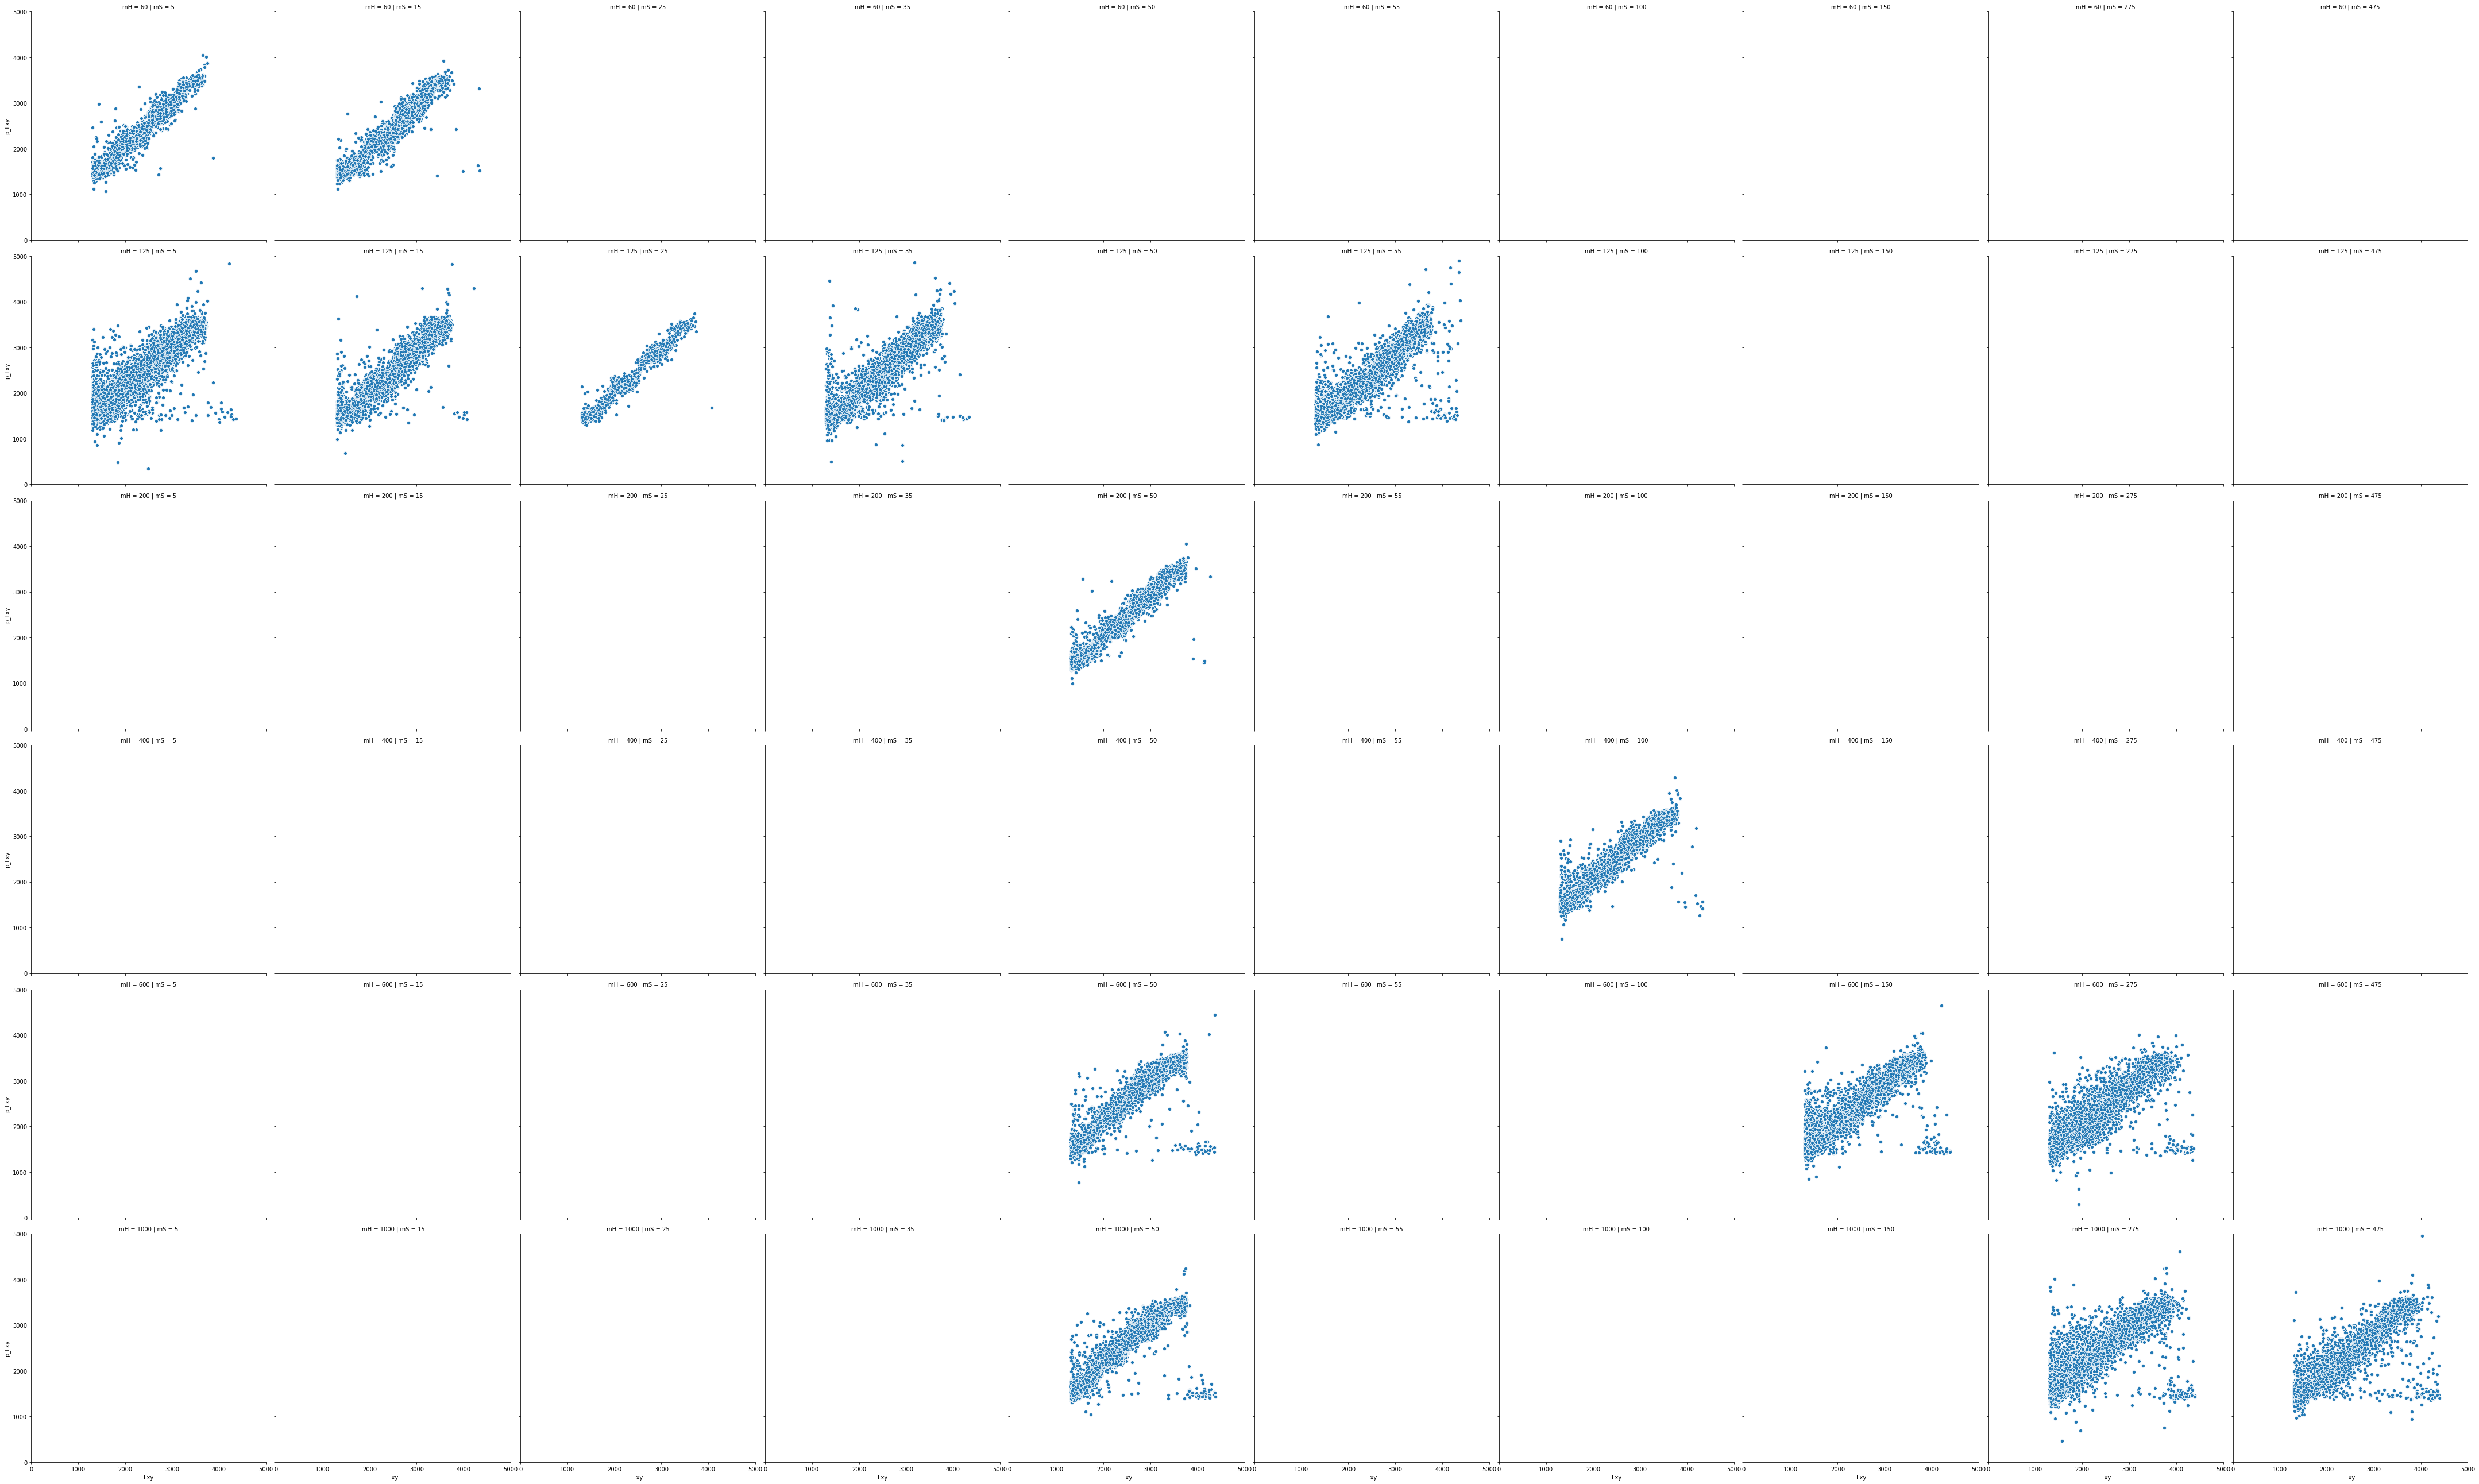

In [20]:
mass_comparison = sns.relplot(x='Lxy', y='p_Lxy', kind='scatter', data=all_testing_jets, row='mH', col='mS', height=6, aspect=1)
mass_comparison.set(ylim=(0.0, 5000.0))
mass_comparison.set(xlim=(0.0, 5000.0))

In [19]:
what_to_train_on

['EMM_BL0',
 'EMM_BL1',
 'EMM_BL2',
 'EMM_BL3',
 'EMM_EL0',
 'EMM_EL1',
 'EMM_EL2',
 'EMM_EL3',
 'EH_EL0',
 'EH_EL1',
 'EH_EL2',
 'EH_CBL0',
 'EH_CBL1',
 'EH_CVL2',
 'EH_TGL0',
 'EH_TGL1',
 'EH_TGL2',
 'EH_EBL0',
 'EH_EBL1',
 'EH_EBL2']